In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../../lib/')
from frustration_graph import *
import pickle
import os
from tqdm import tqdm

In [2]:
from dwave.system import DWaveSampler, EmbeddingComposite, FixedEmbeddingComposite
import minorminer
import dimod
import dwave.inspector

In [3]:
res_path = "../../Results/Ising_Frustrated/"

L = 20
config = np.zeros((L, L))

ratios = np.linspace(0, 1, 100)

In [33]:
qpu = DWaveSampler() #'defaults'
G_qpu = qpu.to_networkx_graph()

bqm = bqm_frustration(L=L, ratio=0)
G_BQM = dimod.to_networkx_graph(bqm)

emb = minorminer.find_embedding(G_BQM, 
                                G_qpu, 
                                threads=12)

dnx.draw_pegasus_embedding(G_BQM, emb, G_qpu)
sampler = FixedEmbeddingComposite(qpu, embedding=emb) #EmbeddingComposite(qpu)

In [39]:
E_min = sampleset.first.energy
f = 0
configs = []
for record in sampleset.record:
    if E_min == record[1]:
        for state, node in zip(record[0], sampleset.variables):
            split = node.split('-')
            x, y = int(split[0]), int(split[1])
            config[x, y] = state
        
        for j in range(record[2]):
            configs.append(config.tolist())

In [41]:
np.array(configs).shape

(19, 20, 20)

In [104]:
res = []
i = 1
errors = 10
Lattices = []
for ratio in tqdm(ratios):
    bqm = bqm_frustration(L, ratio, 0)
    M = []
    W = []
    W1 = []
    configs = []
    for i in range(errors):
        sampleset = sampler.sample(bqm, num_reads=20, annealing_time=1000, chain_strength=4,
                                        label=f'Ising Frustrated {i}/{ratios.size}')
        
        E_min = sampleset.first.energy
    
        for record in sampleset.record:
            if E_min == record[1]:
                for state, node in zip(record[0], sampleset.variables):
                    split = node.split('-')
                    x, y = int(split[0]), int(split[1])
                    config[x, y] = state
                
                
                configs += [config.tolist()] * record[2]
                M += [np.abs(config.mean())] * record[2]
                W += [wall(config)] * record[2]
                W1 += [wall1(config)] * record[2]
    
    Lattices.append(configs)
    res.append([np.mean(M), np.std(M), np.mean(W), np.std(W), np.mean(W1), np.std(W1)])
    i += 1
    
res = np.array(res)

100%|██████████| 100/100 [15:59<00:00,  9.60s/it]


In [100]:
M = []
W = []
W1 = []
for lattice in Lattices[5]:
    M.append(np.abs(np.mean(lattice)))
    W.append(wall(np.array(lattice)))
    W1.append(wall1(np.array(lattice)))

In [101]:
len(M), np.mean(M)

(19, 0.9989473684210527)

In [108]:
with open(f"../../Results/Ising_Frustrated/DWave/{L}x{L}/lattices", 'wb') as fp:
    pickle.dump(Lattices, fp)

np.save(f"../../Results/Ising_Frustrated/DWave/{L}x{L}/ratios.npy", ratios)

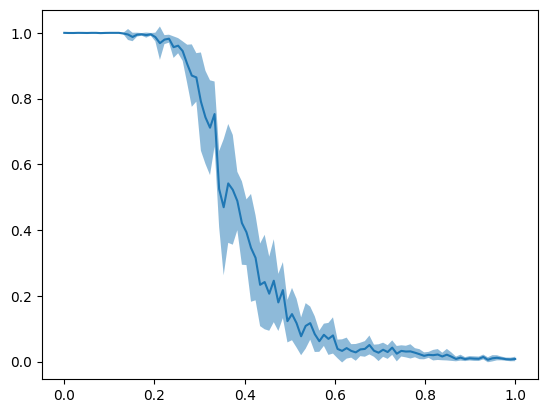

In [107]:
plt.plot(ratios, res[:, 0])
plt.fill_between(ratios, res[:, 0]-res[:, 1], res[:, 0]+res[:, 1], alpha=0.5)

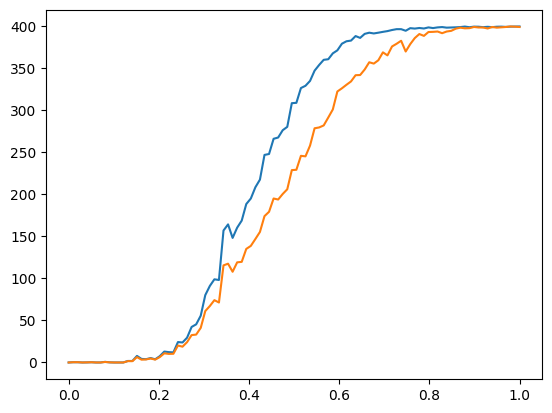

In [109]:
plt.plot(ratios, res[:, [2,4]])

In [29]:
#np.savetxt('Magnetizations_walls.dat', np.column_stack([ratios, res]))